# 신경망 기초 

참고 사이트 : https://www.tensorflow.org/tutorials?hl=ko

In [32]:
# 필요한 라이브러리 import 
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# 데이터 준비

In [ ]:
# google drive mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# data 읽어오기 , 경로복사 붙여넣기
data = '/content/drive/MyDrive/data/result.txt'
df = pd.read_csv(data, sep=',' )
df.columns = ["y", 'x1', 'x2']
df

,y,x1,x2
0,0,380,3.61
1,1,660,3.67
2,1,800,4.00
3,1,640,3.19
4,0,520,2.93
...,...,...,...
395,1,620,4.00
396,1,560,3.04
397,0,460,2.63
398,1,700,3.65


In [ ]:
#데이터의 균형을 살펴보자
df['y'].value_counts()

1    287
0    113
Name: y, dtype: int64

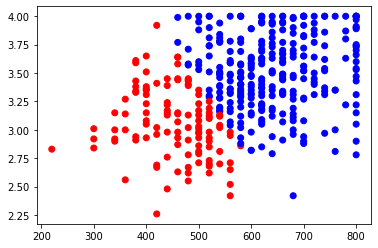

In [ ]:
#plt함수로 데이터를 시각화
fig, ax = plt.subplots()
colors = {0:'red', 1:'blue'}
ax.scatter(df['x1'], df['x2'], c=df['y'].map(colors))
plt.show()

In [ ]:
#전체 n과 test data validation data를 얼마나 나눌것인지 확인
n = 400
ts = 80
vs =80
print(n,ts,vs)

400 80 80


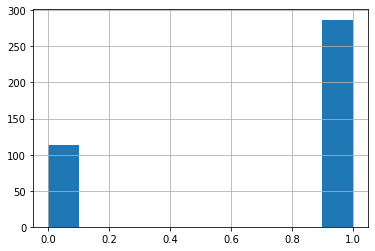

In [ ]:
#이진분류류 0과1의 분포를 히스토그램으로 나타내었다.
df['y'].hist()

In [ ]:
# train, test, validataion data로 분리 , 400개의 데이터를 ts, vs 사이즈 80개씩 분리 
train_df, test_df = train_test_split(df, test_size=ts,random_state=123) #test_size=80이니까 train_df=320
train_df, val_df = train_test_split(train_df, test_size=vs,random_state=123) #train_df중에서 80개를 또 뽑아줬어
len(train_df) #마지막으로 남은train data는 240

240

# 모델링

In [ ]:
#train method를 활용하자, pop은 특정열(y)로 명령된 열만 뽑아와
# 입력데이터로 정리  
y_train = train_df.pop('y')
x_train = train_df
y_test = test_df.pop('y')
x_test = test_df
y_val = val_df.pop('y')
x_val = val_df
x_train

,x1,x2
354,540,3.78
225,720,3.50
294,480,2.55
12,760,4.00
156,560,2.52
...,...,...
318,480,3.71
307,580,3.51
200,800,3.31
262,520,3.19


In [ ]:
# input_shape, 입력변수의 개수 확인, 지금은 독립변수가 둘이기 때문에 2
train_features = np.array(train_df)
train_features.shape[-1]

2

In [ ]:
# model.add를 통해 다층의 layer를 쌓아서 모델링, 훈련에 사용할 옵티마이저(optimizer)와 손실 함수를 선택 
model = keras.models.Sequential()
model.add(keras.layers.Dense(8, activation='relu', input_shape=(train_features.shape[-1],)))
model.add(keras.layers.Dense(8, activation='relu')) #다시 증폭 8*8
model.add(keras.layers.Dropout(0.5)) #overfitting을 방지하기위한 테크닉중 하나
model.add(keras.layers.Dense(1, activation='sigmoid')) #sigmoid는 0~1의 값을 갖는 값을 출력, 0.5<x 면 1 0.5>x면 0

#최적화 optimizer = adam을 선택, 이 과정을 어떻게 하느냐에 따라 값이 많이 달라져
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
#모델 요약해서 보기, paramater값이 많아지면 그만큼 데이터가 많아져야한다, 총 param=105개
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 8)                 24        
                                                                 
 dense_4 (Dense)             (None, 8)                 72        
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0         
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 105
Trainable params: 105
Non-trainable params: 0
_________________________________________________________________


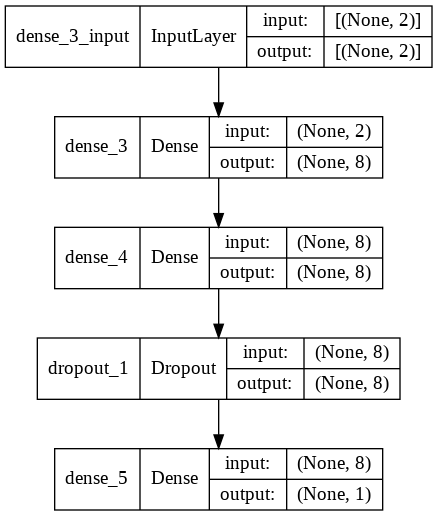

In [ ]:
#모델의 workflow를 확인
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

# Training

In [ ]:
# 모델 저장 설정, 어떻게 저장?
save_weights = tf.keras.callbacks.ModelCheckpoint("model.hdf6",
                                                  monitor='val_accuracy',
                                                  verbose=1,
                                                  save_best_only=True,
                                                  mode="max",
                                                  save_freq="epoch",
                                                  save_weights_only=True)

In [ ]:
# 모델 학습 및 필요 데이터 저장 , epochs=40 전체 프로세스를 몇번 반복할 것이냐, 한 epochs를 돌때 batch를 256으로 하겠다(대중적임).
history = model.fit(x_train, y_train, validation_data=(x_val, y_val) ,
                    epochs=40, 
                    batch_size=256,
                    callbacks=[save_weights])

# 평가

In [ ]:
# model.evaluate로 평가, 훈련된 이미지 분류기는 이 데이터셋에서 거의 69%의 정확도를 달성
loss, accuracy = model.evaluate(x_test,  y_test, verbose=2)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

3/3 - 0s - loss: 4.9703 - accuracy: 0.6875 - 18ms/epoch - 6ms/step
Loss:  4.970304489135742
Accuracy:  0.6875


In [ ]:
# 학습간 저장된 데이터 확인
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

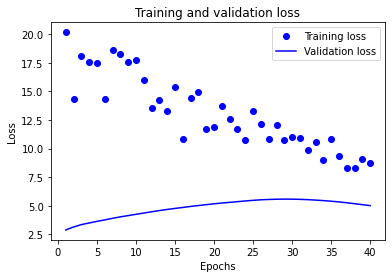

In [ ]:
# 손실과 정확도 도식 , loss는 작을수록 좋은거야
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()
#시간이 지날수록 training loss는 감소하고 validation loss는 살짝 증가한다.

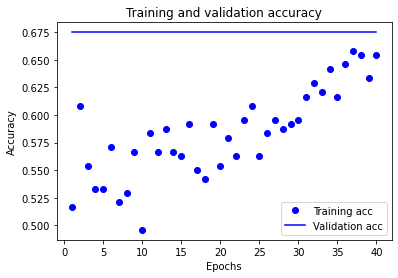

In [ ]:
#validation acc가 높아지다가 어느순간에 감소하는 구간이 있을경우 가장 높은 값을 적용시켜
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()
#training acc는 0.675로 일정하고 validation acc는 상승추세를 보인다.

# 배포 

In [48]:
#임의로 new_x를 만들어 시험데이터를 생성했다.
new_x= np.array([[570,3.78],[460,2.64],[300,3.1],[409,2.64]])
new_x
pd.DataFrame(new_x)

,0,1
0,570.0,3.78
1,460.0,2.64
2,300.0,3.10
3,409.0,2.64


In [50]:
# 저장된 모델 호출 
model.load_weights('model.hdf6')

y_pred = model.predict(new_x)
print(np.round(y_pred).astype(int))

[[1]
 [1]
 [1]
 [1]]


In [ ]:
'''질문3)
모델의 정확도 향상을 위해 일단 딥러닝 모델이기에 train data의 양이 많아야합니다. 
그리고 그 데이터의 균형이 맞춰져있어야 높은 정확도를 뽑아낼 수 있습니다.
히스토그램으로 살펴보니 0의 데이터 값이 100개 1의 데이터 값이 300개 정도인 것을 볼 수 있습니다.
데이터의 양이 많다면 정확도가 68%보다 더 높게 할 수 있을 것 같습니다. 
그리고 paramater의 수를 많이 증폭시켜 loss의 값을 많이 낮출 수 있는 최적의 값을 도출하기 조금 더 편해집니다.'''